In [24]:
# Goal: Fit Piro2021 relation to the bbfit-r(t) curve
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
warnings.filterwarnings("ignore", module="speclite.filters")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import pandas as pd
from scipy.optimize import differential_evolution
import numba

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.blackbody as blackbody
import snelib19odp.analysis.piro2020 as piro2021
import snelib19odp.analysis.blackbody as bbfit

In [25]:
CM_TO_RSUN = u.cm.to(u.Rsun)
D_TO_S = u.d.to(u.s)
KM_TO_CM = u.km.to(u.cm)

phot_rad = np.vectorize(piro2021.photospheric_radius)

def fit_func(x, mjds, obs, obs_err):
    t_expl, t_photospheric, outer_density_index, expansion_velocity = x
    inner_density_index = 1.1
    
    model = phot_rad((mjds-t_expl)*D_TO_S, t_photospheric, inner_density_index, outer_density_index, expansion_velocity)
    sigma2 = obs_err ** 2
    return np.nansum(
        (model-obs)**2 / sigma2
        + np.log(sigma2)
    )

def fit_piro(ds, bands, fine=False):
    mjd_peak = ds.transient.prior_t0
    label = f"{ds.transient.name} {bands}"
    data = bbfit.run_observation_grid(ds, bands, progressbar=False, fine_pre_peak_grid=fine)
    
    mjd_grid = np.array([x.mjd for x in data if x.mjd < ds.transient.prior_t0])
    temps = np.empty_like(mjd_grid)
    temp_errs = np.empty_like(mjd_grid)
    rads = np.empty_like(mjd_grid)
    rad_errs = np.empty_like(mjd_grid)
    for i, mjd in enumerate(mjd_grid):
        #obs_mags, obs_mags_errs, sampler, results = data[i]
        results = data[i].results
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
        trace = dyfunc.resample_equal(samples, weights)
        temps[i], temp_errs[i] = np.mean(trace[:,0]), np.std(trace[:,0])
        t_rads = np.exp(trace[:,1])#*CM_TO_RSUN
        rads[i], rad_errs[i] = np.mean(t_rads), np.std(t_rads)
    
    bounds = [
        (58714.5-2, 58714.5+2),
        (0.01*D_TO_S, 100*D_TO_S),
        (5.5, 10),
        (5000*KM_TO_CM, 16000*KM_TO_CM)
    ]
    result = differential_evolution(fit_func, bounds, args=(mjd_grid, rads, rad_errs))
    print(result)
    print('Velocity: ', result.x[3]/KM_TO_CM)
    print('t_phot: ', result.x[1]/D_TO_S)
    print('n: ', result.x[2])
    inner_density_index = 1.1
    t_expl, t_photospheric, outer_density_index, expansion_velocity = result.x
    model = phot_rad((mjd_grid-t_expl)*D_TO_S, t_photospheric, inner_density_index, outer_density_index, expansion_velocity)
    plt.plot(mjd_grid-t_expl, model, label='Model')
    plt.plot(mjd_grid-t_expl, rads, label='Observed')

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


     fun: 1088.4655705761231
     jac: array([ 2.27438137e-05,  2.27107558e-05, -1.77597016e+00, -1.42692065e-08])
 message: 'Optimization terminated successfully.'
    nfev: 700
     nit: 10
 success: True
       x: array([5.87156738e+04, 1.98758880e+06, 1.00000000e+01, 5.82642267e+08])
Velocity:  5826.422668431572
t_phot:  23.004499945089478
n:  10.0


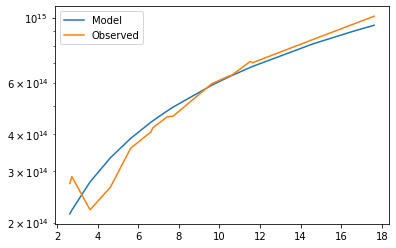

In [26]:
fit_piro(dataset.load_dataset('SN2019odp_phot'), 'gri', fine=True)
plt.legend()
plt.yscale('log')

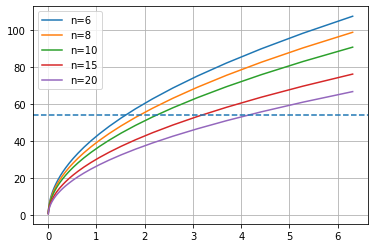

In [27]:
opacity = 0.07
me = np.logspace(-3, 0.8) * u.Msun.to(u.g)
inner_density_index = 1.1

for n in [6,8,10,15,20]:
    outer_density_index = n
    expansion_velocity = 5330 * KM_TO_CM
    t_ph = piro2021.photospheric_timescale(opacity, me, inner_density_index, outer_density_index, expansion_velocity)
    plt.plot(me * u.g.to(u.Msun), t_ph/D_TO_S, label=f"n={n}")
plt.legend()
plt.grid()
plt.axhline(54, ls='--')

In [39]:
CM_TO_RSUN = u.cm.to(u.Rsun)
D_TO_S = u.d.to(u.s)
KM_TO_CM = u.km.to(u.cm)
MSUN_TO_G = u.Msun.to(u.g)



#@numba.njit
def fit_func_nested(x, mjds, obs, obs_err):
    t_expl, envelope_mass, inner_density_index, outer_density_index, expansion_velocity = x
    opacity = 0.07
    #inner_density_index = 1.1
    t_photospheric = piro2021.photospheric_timescale(opacity, envelope_mass*MSUN_TO_G, inner_density_index, outer_density_index, expansion_velocity*KM_TO_CM)
    
    model = np.empty_like(mjds)
    for i in numba.prange(len(mjds)):
        model[i]=piro2021.photospheric_radius((mjds[i]-t_expl)*D_TO_S, t_photospheric, inner_density_index, outer_density_index, expansion_velocity*KM_TO_CM)
    #model = piro2021.photospheric_radius((mjds-t_expl)*D_TO_S, t_photospheric, inner_density_index, outer_density_index, expansion_velocity*KM_TO_CM)
    sigma2 = obs_err ** 2
    return -0.5*np.nansum(
        (model-obs)**2 / sigma2
        + np.log(sigma2)
    )

@numba.njit
def prior_nested(u):
    x = np.empty_like(u)
    
    # t_explosion [d]
    x[0] = (58714.5-2) + 4*u[0]
    
    # M envelope [Msun]
    x[1] = 6*u[1]
    
    # inner density index
    x[2] = 0.1*u[2] + 1.05
    
    # outer density index
    x[3] = 10*u[3] + 5.5
    
    # expansion velocity [km/s]
    x[4] = 9000*u[4] + 5000
    
    return x

def fit_piro_nested(ds, bands, fine=False):
    mjd_peak = ds.transient.prior_t0
    label = f"{ds.transient.name} {bands}"
    data = bbfit.run_observation_grid(ds, bands, progressbar=False, fine_pre_peak_grid=fine)
    
    mjd_grid = np.array([x.mjd for x in data if x.mjd < ds.transient.prior_t0])
    temps = np.empty_like(mjd_grid)
    temp_errs = np.empty_like(mjd_grid)
    rads = np.empty_like(mjd_grid)
    rad_errs = np.empty_like(mjd_grid)
    for i, mjd in enumerate(mjd_grid):
        #obs_mags, obs_mags_errs, sampler, results = data[i]
        results = data[i].results
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
        trace = dyfunc.resample_equal(samples, weights)
        temps[i], temp_errs[i] = np.mean(trace[:,0]), np.std(trace[:,0])
        t_rads = np.exp(trace[:,1])#*CM_TO_RSUN
        rads[i], rad_errs[i] = np.mean(t_rads), np.std(t_rads)
    
    sampler = dynesty.DynamicNestedSampler(fit_func_nested, prior_nested, ndim=5, logl_args=(mjd_grid, rads, rad_errs))
    sampler.run_nested()
    return sampler, mjd_grid, rads, rad_errs

In [40]:
sampler, mjds, rads, rads_err = fit_piro_nested(dataset.load_dataset('SN2019odp_phot'), 'gri', fine=True)

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
19838it [02:13, 148.41it/s, batch: 10 | bound: 62 | nc: 1 | ncall: 59802 | eff(%): 33.173 | loglstar: -549.311 < -541.650 < -542.235 | logz: -548.497 +/-  0.148 | stop:  0.987]     


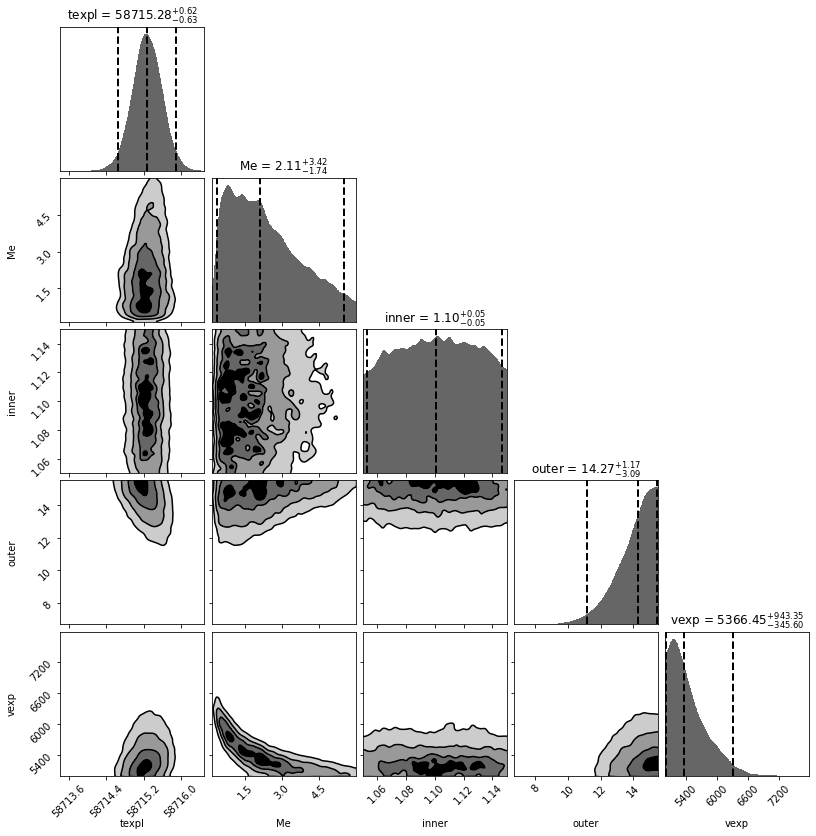

In [38]:
dyplot.cornerplot(sampler.results, labels=['texpl', 'Me', 'inner', 'outer', 'vexp'], show_titles=True);

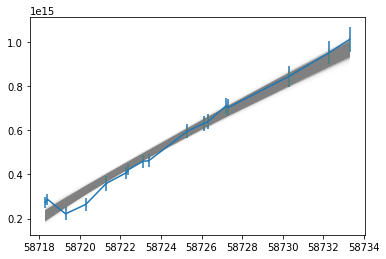

In [45]:
plt.errorbar(mjds, rads, yerr=rads_err)

results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)

phot_rad = np.vectorize(piro2021.photospheric_radius)

for i in range(5000):
    idx = np.random.randint(0, trace.shape[0])
    x = trace[idx]
    
    t_expl, envelope_mass, inner_density_index, outer_density_index, expansion_velocity = x
    t_photospheric = piro2021.photospheric_timescale(opacity, envelope_mass*MSUN_TO_G, inner_density_index, outer_density_index, expansion_velocity*KM_TO_CM)
    
    model = phot_rad((mjds-t_expl)*D_TO_S, t_photospheric, inner_density_index, outer_density_index, expansion_velocity*KM_TO_CM)
    
    plt.plot(mjds, model, alpha=0.05, color='grey', lw=0.1)